# Practico Mentoria - Aprendizaje No Supervisado

El objectivo de este practico es realizar [Clustering](https://es.wikipedia.org/wiki/Algoritmo_de_agrupamiento) sobre el Dataset de las Caracteristicas de los jugadores.

De forma de juntar en los clusters a los jugadores con caracteristicas similares, y en particular de este practico analizar si estos clusters se corresponden con la posicion en la que juegan estos jugadores.

---

### Importaciones

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import warnings

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [4]:
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

In [5]:
# Seteamos una semilla para Reproducibilidad
np.random.seed(1)

---

### Carga del Dateset

In [6]:
player_df = pd.read_csv('../Datasets/football_player_full.csv', index_col='player_name')

#player_df.set_index('player_name', inplace=True)
print("Shape 'player_df' = {}".format(player_df.shape))

# Copy Dataframe
player2_df = player_df.copy(deep=False)

Shape 'player_df' = (9925, 36)


In [7]:
player_df.sample(10)

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,position
player_name,,,,,,,,,,,,,,,,,,,,,
Ariel Borysiuk,66.12,74.38,56.92,49.79,49.38,67.25,58.88,64.08,45.79,52.38,...,49.21,51.58,63.58,63.08,12.71,13.04,18.71,15.54,13.04,MID
Sava Miladinovic Bento,58.00,64.43,51.07,44.86,42.93,58.14,46.21,58.29,50.64,52.86,...,49.50,41.64,46.57,40.07,8.00,8.00,8.00,7.00,14.00,MID
Dusan Tadic,78.16,81.88,81.52,68.36,56.64,78.60,69.84,81.36,79.72,73.08,...,76.28,39.96,35.56,27.56,10.16,10.16,12.56,8.16,15.16,MID
Samuel Souprayen,64.24,71.76,58.29,20.76,57.19,56.90,22.10,55.71,61.67,31.67,...,42.71,65.62,65.19,66.90,8.33,10.95,15.19,14.19,14.19,DEF
Daniele Croce,67.68,67.68,63.32,51.58,44.74,72.16,53.89,66.16,54.95,58.74,...,59.74,52.26,56.89,59.53,11.74,11.74,5.74,7.74,12.74,MID
John Arne Riise,76.32,77.64,84.00,60.82,67.05,78.32,75.05,69.41,74.05,77.55,...,70.59,75.45,79.59,80.59,13.27,10.09,33.14,13.50,13.68,DEF
Saidy Janko,62.13,76.53,58.73,40.60,56.73,51.20,34.27,67.07,41.73,36.27,...,51.20,58.53,65.87,64.60,5.27,9.27,7.27,13.27,7.27,DEF
Helder Postiga,76.04,76.93,59.33,71.19,78.19,64.56,78.56,73.56,65.81,52.85,...,70.59,25.37,28.11,27.19,12.00,9.81,20.67,16.37,14.59,FW
Denzel Slager,61.50,70.75,60.25,59.00,43.00,58.75,59.00,65.12,64.00,48.00,...,50.00,20.62,20.00,21.00,14.00,8.00,11.00,11.00,15.00,FW


In [8]:
player_df.dtypes

overall_rating        float64
potential             float64
crossing              float64
finishing             float64
heading_accuracy      float64
short_passing         float64
volleys               float64
dribbling             float64
curve                 float64
free_kick_accuracy    float64
long_passing          float64
ball_control          float64
acceleration          float64
sprint_speed          float64
agility               float64
reactions             float64
balance               float64
shot_power            float64
jumping               float64
stamina               float64
strength              float64
long_shots            float64
aggression            float64
interceptions         float64
positioning           float64
vision                float64
penalties             float64
marking               float64
standing_tackle       float64
sliding_tackle        float64
gk_diving             float64
gk_handling           float64
gk_kicking            float64
gk_positio

In [9]:
# Guardamos la lista de la posicion de los jugadores
from collections import Counter
player_position_list = player_df.position.tolist()
player_position_dict = Counter(player_position_list)
player_position_dict

Counter({'DEF': 3664, 'MID': 3473, 'GK': 869, 'FW': 1919})

In [10]:
player_df = player_df[[
    'overall_rating', 'potential', 'crossing', 'finishing', 'heading_accuracy',
    'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
    'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility',
    'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength',
    'long_shots', 'aggression', 'interceptions', 'positioning', 'vision',
    'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
    'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes',
]]

In [11]:
player_df.dtypes

overall_rating        float64
potential             float64
crossing              float64
finishing             float64
heading_accuracy      float64
short_passing         float64
volleys               float64
dribbling             float64
curve                 float64
free_kick_accuracy    float64
long_passing          float64
ball_control          float64
acceleration          float64
sprint_speed          float64
agility               float64
reactions             float64
balance               float64
shot_power            float64
jumping               float64
stamina               float64
strength              float64
long_shots            float64
aggression            float64
interceptions         float64
positioning           float64
vision                float64
penalties             float64
marking               float64
standing_tackle       float64
sliding_tackle        float64
gk_diving             float64
gk_handling           float64
gk_kicking            float64
gk_positio

In [12]:
player_df.sample(10)

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
player_name,,,,,,,,,,,,,,,,,,,,,
Rolando Mandragora,60.93,73.13,47.87,44.33,48.07,69.33,41.67,60.07,49.67,33.67,...,65.07,31.67,46.67,57.00,52.73,12.67,13.67,8.67,13.67,15.67
Daniel Pinillos,59.71,66.14,59.57,32.14,48.14,48.29,33.14,52.29,57.57,39.14,...,43.86,46.14,57.86,63.57,70.43,6.14,15.14,10.14,12.14,6.14
Stopira,60.25,65.00,56.00,28.00,32.00,49.00,32.00,44.00,47.00,42.00,...,51.00,45.00,62.00,59.50,66.00,8.00,13.00,11.00,13.00,5.00
Kakha Kaladze,78.50,83.10,67.30,32.80,77.10,71.20,46.00,51.70,44.00,48.30,...,61.00,64.20,81.90,81.60,72.70,11.00,15.30,49.10,14.60,17.80
Sergi Darder,69.43,75.61,48.91,39.13,35.65,77.17,36.04,63.83,61.87,54.26,...,75.00,38.26,52.61,64.48,61.13,6.26,9.26,5.26,13.26,5.26
Zeljko Brkic,75.00,77.12,18.50,19.00,17.50,32.71,16.58,20.17,17.88,18.42,...,27.33,31.54,19.00,19.92,20.92,80.58,70.00,59.50,76.88,78.92
Stephen Elliott,66.50,70.93,52.79,67.14,65.64,59.79,61.14,64.21,52.00,47.71,...,64.93,63.43,32.50,31.43,25.00,13.57,10.79,22.79,9.29,9.43
Adil Ramzi,66.17,66.17,61.67,55.67,50.00,71.00,54.00,69.33,49.00,70.00,...,70.67,75.00,48.67,33.33,35.33,12.00,6.00,10.00,10.00,9.00
Igor Bubnjic,69.47,76.18,28.76,20.59,68.12,45.65,30.12,36.12,34.76,34.12,...,34.06,43.12,74.12,75.59,72.29,11.76,11.76,13.76,12.76,4.76


---

> ### Aplicar Clustering sobre las features de los jugadores

Usar [K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) para el clustering.

Probar primero con 4 clusters, este numero se debe a cantidad de clases con respecto a la posicion de los jugadores:
* **GK**: Goalkeeper (Arquero)
* **DEF**: Defenser (Defensor)
* **MID**: Midfielder (Mediocampistas)
* **FW**: Forward (Delantero)

Luedo de hacer clustering, ver cuantos elementos tiene cada cluster.

In [101]:
kmeans = KMeans(n_clusters=4, n_jobs=-1)
kmeans.fit(player_df)
player_df_clusters=player_df.copy()
player_df_clusters['kmedias_4']=kmeans.labels_
print(kmeans)
player_df_clusters.head(10)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,kmedias_4
player_name,,,,,,,,,,,,,,,,,,,,,
Aaron Appindangoye,63.60,67.60,48.60,43.60,70.60,60.60,43.60,50.60,44.60,38.60,...,47.60,63.80,66.00,67.80,5.60,10.60,9.60,7.60,7.60,0
Aaron Cresswell,66.97,74.48,70.79,49.45,52.94,62.27,29.15,61.09,61.88,62.12,...,53.12,69.39,68.79,71.52,12.18,8.67,14.24,10.36,12.91,3
Aaron Doran,67.00,74.19,68.12,57.92,58.69,65.12,54.27,69.04,60.19,55.62,...,60.54,22.04,21.12,21.35,14.04,11.81,17.73,10.12,13.50,1
Aaron Galindo,69.09,70.78,57.22,26.26,69.26,64.70,47.78,55.57,37.78,40.39,...,41.74,70.61,70.65,68.04,14.17,11.17,22.87,11.17,10.17,0
Aaron Hughes,73.24,74.68,45.08,38.84,73.04,64.76,32.08,50.60,45.48,26.36,...,52.96,77.60,76.04,74.60,8.28,8.32,24.92,12.84,11.92,0
Aaron Hunt,77.26,80.15,73.89,72.81,65.52,78.26,77.67,78.81,77.85,68.44,...,75.59,31.70,31.52,32.33,13.22,12.41,15.07,15.56,14.85,1
Aaron Kuhl,60.57,76.00,47.57,31.57,46.57,63.57,33.57,53.57,55.57,39.57,...,41.57,51.57,57.14,56.57,7.57,12.57,13.57,13.57,14.57,0
Aaron Lennon,79.77,82.00,78.04,65.96,30.46,76.27,68.38,85.19,62.08,54.35,...,63.46,23.23,26.15,20.88,12.85,9.81,17.88,16.92,13.12,1
Aaron Lennox,48.00,56.86,12.00,15.00,16.00,23.00,14.00,15.00,14.00,18.00,...,41.00,15.00,15.00,12.00,53.00,41.00,39.00,51.00,53.00,2


In [102]:
player_df_clusters['kmedias_4'].value_counts().sort_values()

2     869
0    2673
3    2877
1    3506
Name: kmedias_4, dtype: int64

> ##### Evaluar resultados

Evaluar los resultados del clustering usando una medida como la [Pureza](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html).


**Hint 1**: Puede que en los clusters haya confusion entre las distintas posiciones dentro del campo de juego, esto no esta mal. Ya que hay que recordar que las posiciones estan simplicadas.


**Hint 2**: Un indicador de mala calidad es que haya clusters muy chiquitos y uno muy grande, lo cual indica que en el espacio no se distinguen bien grupos separados y hay que usar otro espacio.

In [197]:
# Positions and Labels
pos_label = pd.DataFrame(
    {
        'player_name': player_df.index.tolist(),
        'position': player_position_list,
        'cluster': player_df_clusters['kmedias_4'].tolist()
    },
    columns = ['player_name', 'position', 'cluster']
)
pos_label.sort_values("position")
GKs = len(pos_label[pos_label.position == "GK"])
DEFs = len(pos_label[pos_label.position == "DEF"])
MIDs = len(pos_label[pos_label.position == "MID"])
FWs = len(pos_label[pos_label.position == "FW"])

print(pos_label.groupby(["cluster"])['position'].apply(pd.Series.mode))

cluster_0 = pos_label[(pos_label.cluster == 0) & (pos_label.position == "DEF")]
cluster_1 = pos_label[(pos_label.cluster == 1) & (pos_label.position == "FW")]
cluster_2 = pos_label[(pos_label.cluster == 2) & (pos_label.position == "GK")]
cluster_3 = pos_label[(pos_label.cluster == 3) & (pos_label.position == "MID")]

cluster   
0        0    DEF
1        0     FW
2        0     GK
3        0    MID
Name: position, dtype: object


In [198]:
# player_position_dict = {'DEF': 3664, 'MID': 3473, 'GK': 869, 'FW': 1919}
gk_purity = len(cluster_2)/GKs
def_purity = len(cluster_0)/DEFs
mid_purity = len(cluster_3)/MIDs
fw_purity = len(cluster_1)/FWs
purity = (gk_purity + fw_purity + mid_purity + def_purity) / 4
print("GK purity: {}\nFW purity: {}\nMID purity: {}\nDEF purity: {}".format(
    gk_purity, fw_purity, mid_purity, def_purity))
print("\nOverall purity: {}".format(purity))

GK purity: 1.0
FW purity: 0.9801980198019802
MID purity: 0.4592571264036856
DEF purity: 0.6596615720524017

Overall purity: 0.7747791795645169


> ### Diferentes numero de clusters

Usar diferentes numero de clusters, especialmente numeros altos, para observar las subdivisiones de las clases, y que clases se confunden mas.


**Nota**: Las posiciones asignadas a los jugadores son simplificadas, esto quiere decir que al hacer mas de 4 clusters podemos llegar descubrir posiciones mas especificas dentro del campo de juego (por ejemplo: Defensor central, Lateral derecho/izquierdo, Mediocampista defensivo/ofensivo, etc.)


**Recordar**: Calcular la Pureza para analizar si tener una mayor cantidad de clusters da mejores resultados.

In [110]:
kmeans8 = KMeans(n_clusters=8, n_jobs=-1)
kmeans8.fit(player_df)
player_df_clusters['kmedias_8']=kmeans8.labels_
print(kmeans8)
player_df_clusters.head(10)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,kmedias_4,kmedias_8
player_name,,,,,,,,,,,,,,,,,,,,,
Aaron Appindangoye,63.60,67.60,48.60,43.60,70.60,60.60,43.60,50.60,44.60,38.60,...,63.80,66.00,67.80,5.60,10.60,9.60,7.60,7.60,0,7
Aaron Cresswell,66.97,74.48,70.79,49.45,52.94,62.27,29.15,61.09,61.88,62.12,...,69.39,68.79,71.52,12.18,8.67,14.24,10.36,12.91,3,1
Aaron Doran,67.00,74.19,68.12,57.92,58.69,65.12,54.27,69.04,60.19,55.62,...,22.04,21.12,21.35,14.04,11.81,17.73,10.12,13.50,1,0
Aaron Galindo,69.09,70.78,57.22,26.26,69.26,64.70,47.78,55.57,37.78,40.39,...,70.61,70.65,68.04,14.17,11.17,22.87,11.17,10.17,0,7
Aaron Hughes,73.24,74.68,45.08,38.84,73.04,64.76,32.08,50.60,45.48,26.36,...,77.60,76.04,74.60,8.28,8.32,24.92,12.84,11.92,0,7
Aaron Hunt,77.26,80.15,73.89,72.81,65.52,78.26,77.67,78.81,77.85,68.44,...,31.70,31.52,32.33,13.22,12.41,15.07,15.56,14.85,1,6
Aaron Kuhl,60.57,76.00,47.57,31.57,46.57,63.57,33.57,53.57,55.57,39.57,...,51.57,57.14,56.57,7.57,12.57,13.57,13.57,14.57,0,1
Aaron Lennon,79.77,82.00,78.04,65.96,30.46,76.27,68.38,85.19,62.08,54.35,...,23.23,26.15,20.88,12.85,9.81,17.88,16.92,13.12,1,6
Aaron Lennox,48.00,56.86,12.00,15.00,16.00,23.00,14.00,15.00,14.00,18.00,...,15.00,15.00,12.00,53.00,41.00,39.00,51.00,53.00,2,2


In [131]:
# Positions and Labels
pos_label8 = pd.DataFrame(
    {
        'player_name': player_df.index.tolist(),
        'position': player_position_list,
        'cluster4': player_df_clusters['kmedias_4'].tolist(),
        'cluster8': player_df_clusters['kmedias_8'].tolist(),
        'agility': player_df.agility.tolist(),
        'finishing': player_df.finishing.tolist(),
        'standing_tackle': player_df.standing_tackle.tolist(),
        'sprint_speed': player_df.sprint_speed.tolist()
    },
    columns = ['player_name', 'position', 'cluster4', 'cluster8', 
               'agility', 'finishing', 'standing_tackle', 'sprint_speed']
)
print(pos_label8.sort_values("position")[pos_label8.position == 'GK'].drop(['player_name'], axis=1).transpose())
print(pos_label8.sort_values("position")[pos_label8.position == 'DEF'].drop(['player_name'], axis=1).transpose())
print(pos_label8.sort_values("position")[pos_label8.position == 'MID'].drop(['player_name'], axis=1).transpose())
print(pos_label8.sort_values("position")[pos_label8.position == 'FW'].drop(['player_name'], axis=1).transpose())

                  9499   8481   8801  7516   6907 7512   8803   9541   8872  \
position            GK     GK     GK    GK     GK   GK     GK     GK     GK   
cluster4             2      2      2     2      2    2      2      2      2   
cluster8             2      2      2     2      2    2      2      2      2   
agility          59.94     46  65.65  37.2  51.19   61     42   52.2  54.12   
finishing        16.41  15.12  18.85     6  16.77   13  20.53   24.6  14.35   
standing_tackle  24.88  20.35  15.46     6  17.23   20  21.11  24.13     24   
sprint_speed     50.94  49.06  38.46  40.6  42.54   65  40.26   50.8  46.94   

                5973  ...  336    5947   5674   5328   5807   5323   5935  \
position          GK  ...    GK     GK     GK     GK     GK     GK     GK   
cluster4           2  ...     2      2      2      2      2      2      2   
cluster8           2  ...     2      2      2      2      2      2      2   
agility           37  ...    49  42.57   70.8  59.33     31

In [161]:
print("CLUSTER 0: \n", pos_label8[(pos_label8.cluster8 == 0)].describe())
print("CLUSTER 1: \n", pos_label8[(pos_label8.cluster8 == 1)].describe())
print("CLUSTER 2: \n", pos_label8[(pos_label8.cluster8 == 2)].describe())
print("CLUSTER 3: \n", pos_label8[(pos_label8.cluster8 == 3)].describe())
print("CLUSTER 4: \n", pos_label8[(pos_label8.cluster8 == 4)].describe())
print("CLUSTER 5: \n", pos_label8[(pos_label8.cluster8 == 5)].describe())
print("CLUSTER 6: \n", pos_label8[(pos_label8.cluster8 == 6)].describe())
print("CLUSTER 7: \n", pos_label8[(pos_label8.cluster8 == 7)].describe())

CLUSTER 0: 
           cluster4  cluster8      agility    finishing  standing_tackle  \
count  1163.000000    1163.0  1163.000000  1163.000000      1163.000000   
mean      0.985383       0.0    73.976285    57.464832        31.474282   
std       0.120067       0.0     8.083101     7.327474         9.081777   
min       0.000000       0.0    33.000000    29.000000        12.000000   
25%       1.000000       0.0    69.000000    53.355000        24.000000   
50%       1.000000       0.0    74.090000    58.580000        30.110000   
75%       1.000000       0.0    79.365000    63.000000        38.330000   
max       1.000000       0.0    93.110000    73.050000        56.430000   

       sprint_speed  
count   1163.000000  
mean      74.747343  
std        7.517994  
min       32.000000  
25%       69.750000  
50%       75.000000  
75%       79.780000  
max       94.380000  
CLUSTER 1: 
           cluster4  cluster8      agility    finishing  standing_tackle  \
count  1607.000000    160

Text(0.5, 1.0, 'C7-SPRINT SPEED')

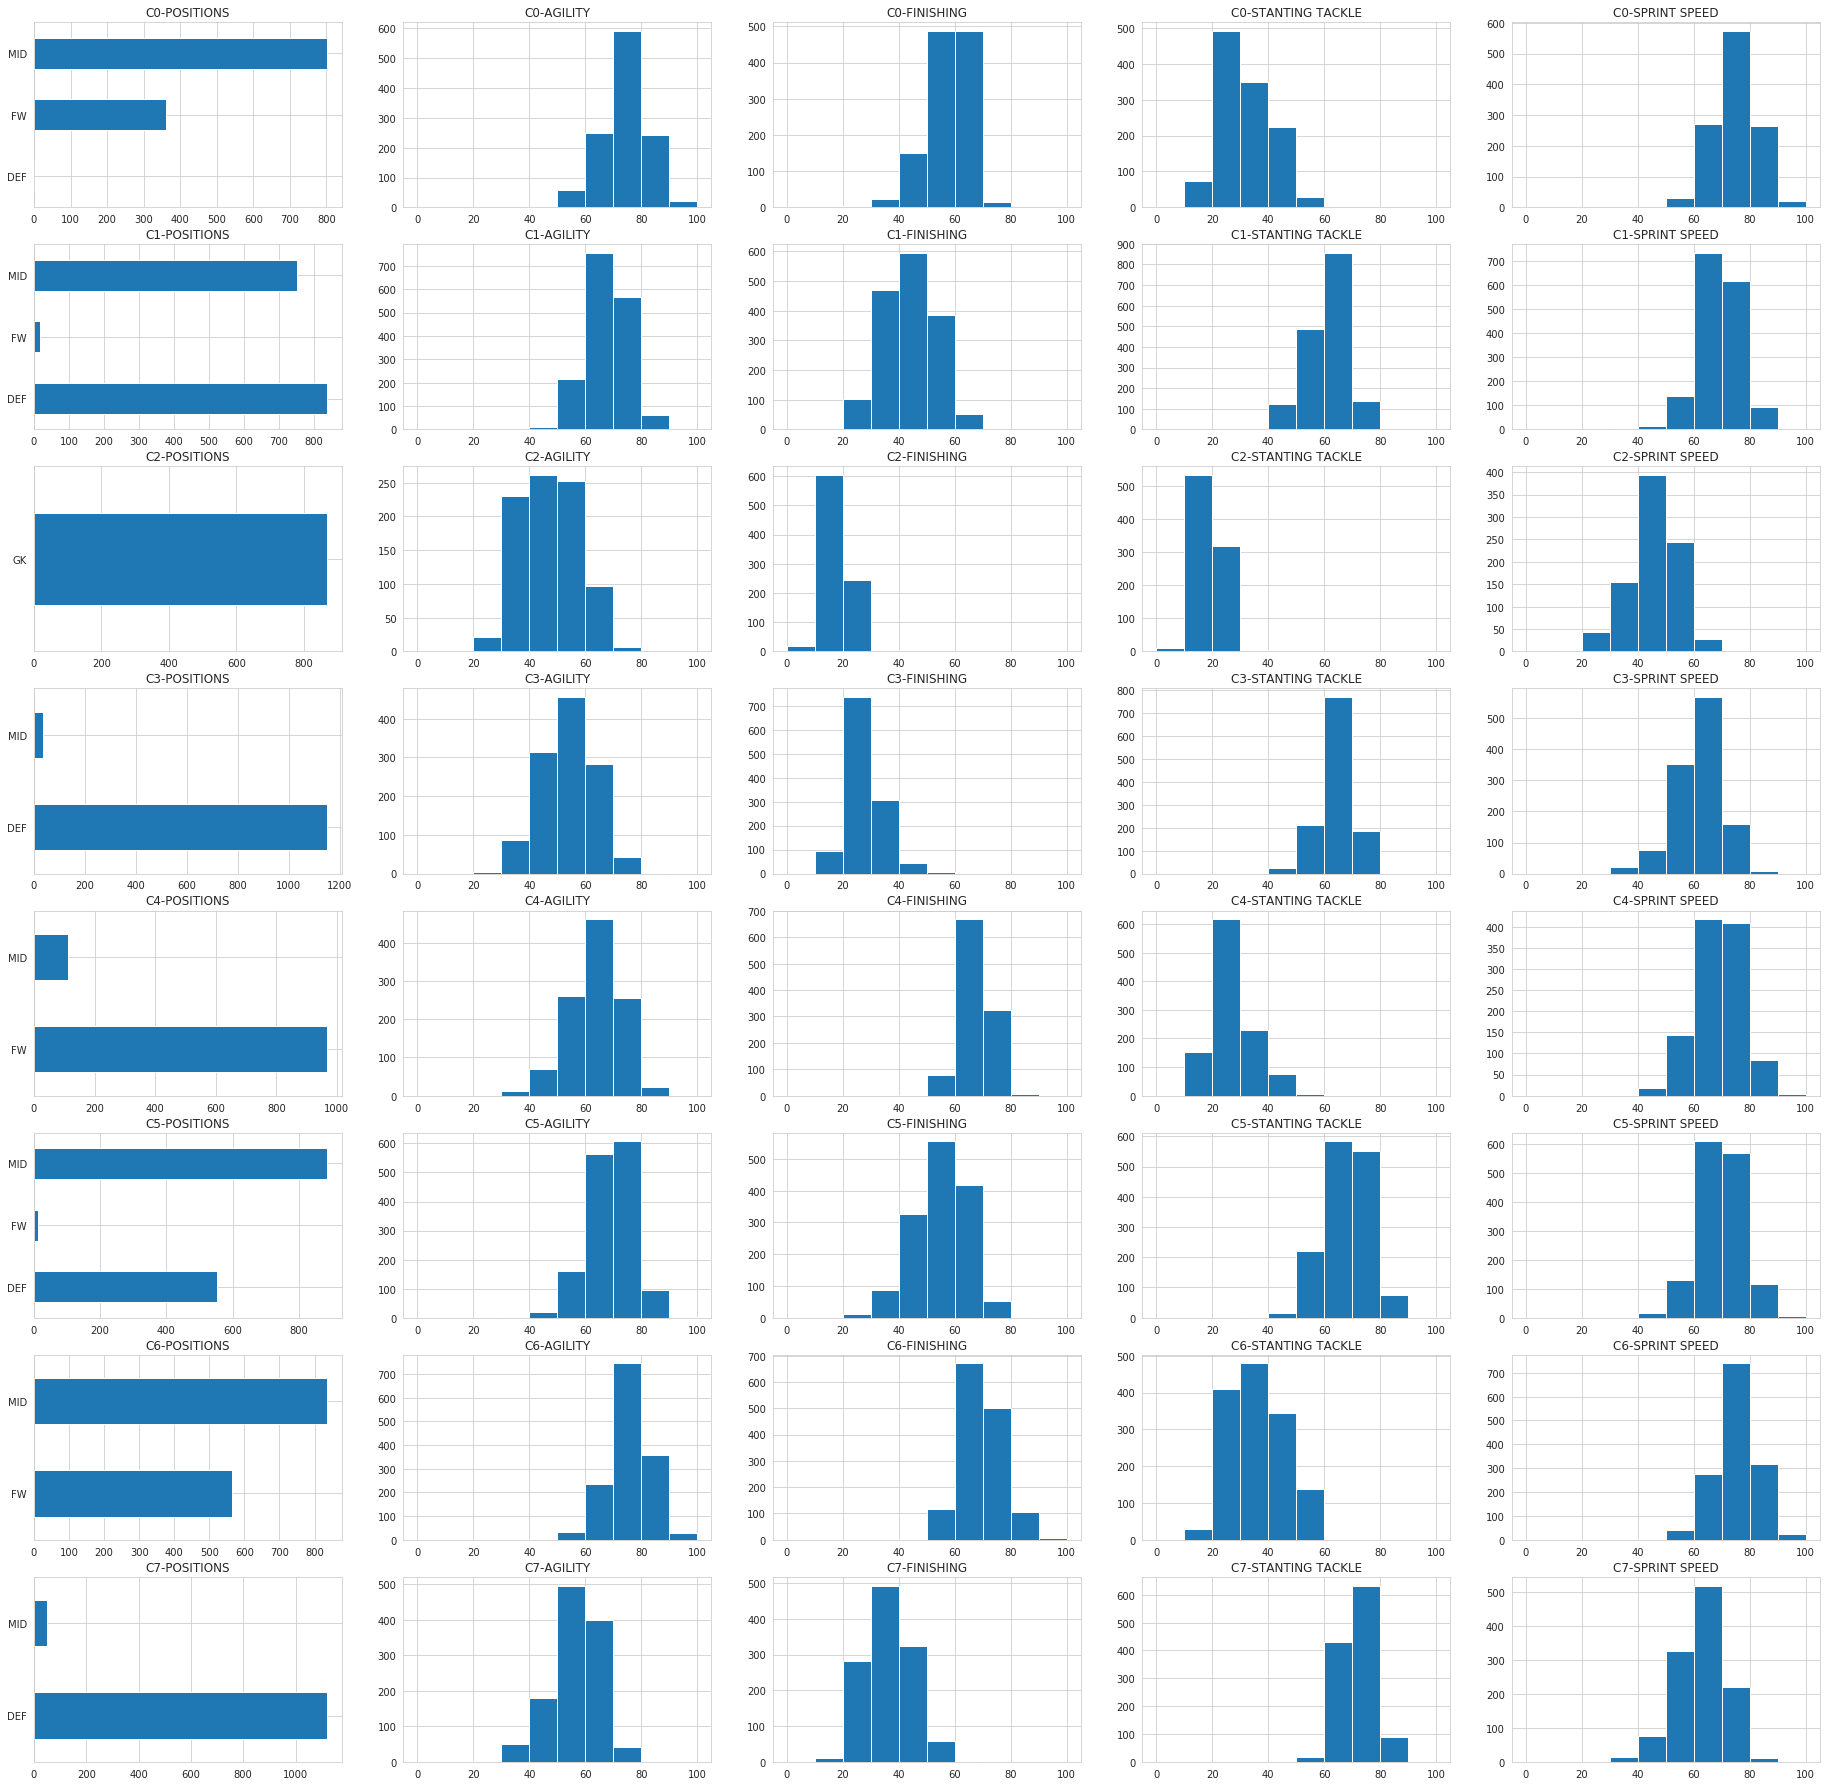

In [194]:
plt.figure(figsize=(32,32))

plt.subplot(8,5,1)
pos_label8[(pos_label8.cluster8 == 0)]['position'].value_counts().sort_index().plot('barh')
plt.title('C0-POSITIONS')
plt.subplot(8,5,2)
plt.hist(pos_label8[(pos_label8.cluster8 == 0)]['agility'], range=(0, 100))
plt.title('C0-AGILITY')
plt.subplot(8,5,3)
plt.hist(pos_label8[(pos_label8.cluster8 == 0)]['finishing'], range=(0, 100))
plt.title('C0-FINISHING')
plt.subplot(8,5,4)
plt.hist(pos_label8[(pos_label8.cluster8 == 0)]['standing_tackle'], range=(0, 100))
plt.title('C0-STANTING TACKLE')
plt.subplot(8,5,5)
plt.hist(pos_label8[(pos_label8.cluster8 == 0)]['sprint_speed'], range=(0, 100))
plt.title('C0-SPRINT SPEED')

plt.subplot(8,5,6)
pos_label8[(pos_label8.cluster8 == 1)]['position'].value_counts().sort_index().plot('barh')
plt.title('C1-POSITIONS')
plt.subplot(8,5,7)
plt.hist(pos_label8[(pos_label8.cluster8 == 1)]['agility'], range=(0, 100))
plt.title('C1-AGILITY')
plt.subplot(8,5,8)
plt.hist(pos_label8[(pos_label8.cluster8 == 1)]['finishing'], range=(0, 100))
plt.title('C1-FINISHING')
plt.subplot(8,5,9)
plt.hist(pos_label8[(pos_label8.cluster8 == 1)]['standing_tackle'], range=(0, 100))
plt.title('C1-STANTING TACKLE')
plt.subplot(8,5,10)
plt.hist(pos_label8[(pos_label8.cluster8 == 1)]['sprint_speed'], range=(0, 100))
plt.title('C1-SPRINT SPEED')


plt.subplot(8,5,11)
pos_label8[(pos_label8.cluster8 == 2)]['position'].value_counts().sort_index().plot('barh')
plt.title('C2-POSITIONS')
plt.subplot(8,5,12)
plt.hist(pos_label8[(pos_label8.cluster8 == 2)]['agility'], range=(0, 100))
plt.title('C2-AGILITY')
plt.subplot(8,5,13)
plt.hist(pos_label8[(pos_label8.cluster8 == 2)]['finishing'], range=(0, 100))
plt.title('C2-FINISHING')
plt.subplot(8,5,14)
plt.hist(pos_label8[(pos_label8.cluster8 == 2)]['standing_tackle'], range=(0, 100))
plt.title('C2-STANTING TACKLE')
plt.subplot(8,5,15)
plt.hist(pos_label8[(pos_label8.cluster8 == 2)]['sprint_speed'], range=(0, 100))
plt.title('C2-SPRINT SPEED')


plt.subplot(8,5,16)
pos_label8[(pos_label8.cluster8 == 3)]['position'].value_counts().sort_index().plot('barh')
plt.title('C3-POSITIONS')
plt.subplot(8,5,17)
plt.hist(pos_label8[(pos_label8.cluster8 == 3)]['agility'], range=(0, 100))
plt.title('C3-AGILITY')
plt.subplot(8,5,18)
plt.hist(pos_label8[(pos_label8.cluster8 == 3)]['finishing'], range=(0, 100))
plt.title('C3-FINISHING')
plt.subplot(8,5,19)
plt.hist(pos_label8[(pos_label8.cluster8 == 3)]['standing_tackle'], range=(0, 100))
plt.title('C3-STANTING TACKLE')
plt.subplot(8,5,20)
plt.hist(pos_label8[(pos_label8.cluster8 == 3)]['sprint_speed'], range=(0, 100))
plt.title('C3-SPRINT SPEED')


plt.subplot(8,5,21)
pos_label8[(pos_label8.cluster8 == 4)]['position'].value_counts().sort_index().plot('barh')
plt.title('C4-POSITIONS')
plt.subplot(8,5,22)
plt.hist(pos_label8[(pos_label8.cluster8 == 4)]['agility'], range=(0, 100))
plt.title('C4-AGILITY')
plt.subplot(8,5,23)
plt.hist(pos_label8[(pos_label8.cluster8 == 4)]['finishing'], range=(0, 100))
plt.title('C4-FINISHING')
plt.subplot(8,5,24)
plt.hist(pos_label8[(pos_label8.cluster8 == 4)]['standing_tackle'], range=(0, 100))
plt.title('C4-STANTING TACKLE')
plt.subplot(8,5,25)
plt.hist(pos_label8[(pos_label8.cluster8 == 4)]['sprint_speed'], range=(0, 100))
plt.title('C4-SPRINT SPEED')


plt.subplot(8,5,26)
pos_label8[(pos_label8.cluster8 == 5)]['position'].value_counts().sort_index().plot('barh')
plt.title('C5-POSITIONS')
plt.subplot(8,5,27)
plt.hist(pos_label8[(pos_label8.cluster8 == 5)]['agility'], range=(0, 100))
plt.title('C5-AGILITY')
plt.subplot(8,5,28)
plt.hist(pos_label8[(pos_label8.cluster8 == 5)]['finishing'], range=(0, 100))
plt.title('C5-FINISHING')
plt.subplot(8,5,29)
plt.hist(pos_label8[(pos_label8.cluster8 == 5)]['standing_tackle'], range=(0, 100))
plt.title('C5-STANTING TACKLE')
plt.subplot(8,5,30)
plt.hist(pos_label8[(pos_label8.cluster8 == 5)]['sprint_speed'], range=(0, 100))
plt.title('C5-SPRINT SPEED')


plt.subplot(8,5,31)
pos_label8[(pos_label8.cluster8 == 6)]['position'].value_counts().sort_index().plot('barh')
plt.title('C6-POSITIONS')
plt.subplot(8,5,32)
plt.hist(pos_label8[(pos_label8.cluster8 == 6)]['agility'], range=(0, 100))
plt.title('C6-AGILITY')
plt.subplot(8,5,33)
plt.hist(pos_label8[(pos_label8.cluster8 == 6)]['finishing'], range=(0, 100))
plt.title('C6-FINISHING')
plt.subplot(8,5,34)
plt.hist(pos_label8[(pos_label8.cluster8 == 6)]['standing_tackle'], range=(0, 100))
plt.title('C6-STANTING TACKLE')
plt.subplot(8,5,35)
plt.hist(pos_label8[(pos_label8.cluster8 == 6)]['sprint_speed'], range=(0, 100))
plt.title('C6-SPRINT SPEED')


plt.subplot(8,5,36)
pos_label8[(pos_label8.cluster8 == 7)]['position'].value_counts().sort_index().plot('barh')
plt.title('C7-POSITIONS')
plt.subplot(8,5,37)
plt.hist(pos_label8[(pos_label8.cluster8 == 7)]['agility'], range=(0, 100))
plt.title('C7-AGILITY')
plt.subplot(8,5,38)
plt.hist(pos_label8[(pos_label8.cluster8 == 7)]['finishing'], range=(0, 100))
plt.title('C7-FINISHING')
plt.subplot(8,5,39)
plt.hist(pos_label8[(pos_label8.cluster8 == 7)]['standing_tackle'], range=(0, 100))
plt.title('C7-STANTING TACKLE')
plt.subplot(8,5,40)
plt.hist(pos_label8[(pos_label8.cluster8 == 7)]['sprint_speed'], range=(0, 100))
plt.title('C7-SPRINT SPEED')

In [196]:
cluster_0_8=pos_label8[(pos_label8.cluster8==0)&(pos_label.position=="MID")] # MID "Creativo" (8-10)
cluster_1_8=pos_label8[(pos_label8.cluster8==1)&(pos_label.position=="DEF")] # DEF "Carrilero" (3-4)
cluster_2_8=pos_label8[(pos_label8.cluster8==2)&(pos_label.position=="GK")] # GK (1)
cluster_3_8=pos_label8[(pos_label8.cluster8==3)&(pos_label.position=="DEF")] # DEF "Stopper" (2-6)
cluster_4_8=pos_label8[(pos_label8.cluster8==4)&(pos_label.position=="FW")] # FW "Area" (9)
cluster_5_8=pos_label8[(pos_label8.cluster8==5)&(pos_label.position=="MID")] # MID "MID Contencion" (5)
cluster_6_8=pos_label8[(pos_label8.cluster8==6)&(pos_label.position=="MID")] # MID "MID Ofensivo" (7-10-11)"
cluster_7_8=pos_label8[(pos_label8.cluster8==7)&(pos_label.position=="DEF")] # DEF "Buena Pegada" (2-6)

In [201]:
gk_purity8 = len(cluster_2_8)/GKs
def_purity8 = (len(cluster_1_8)+len(cluster_3_8)+len(cluster_7_8))/DEFs
mid_purity8 = (len(cluster_0_8)+len(cluster_5_8)+len(cluster_6_8))/MIDs
fw_purity8 = len(cluster_4_8)/FWs
purity8 = (gk_purity8 + fw_purity8 + mid_purity8 + def_purity8) / 4
print("GK purity8: {}\nFW purity8: {}\nMID purity8: {}\nDEF purity8: {}".format(
    gk_purity8, fw_purity8, mid_purity8, def_purity8))
print("\nOverall purity8: {}".format(purity8))
print("\n")
print("GK purity: {}\nFW purity: {}\nMID purity: {}\nDEF purity: {}".format(
    gk_purity, fw_purity, mid_purity, def_purity))
print("\nOverall purity: {}".format(purity))

GK purity8: 1.0
FW purity8: 0.5044293903074518
MID purity8: 0.7267492081773683
DEF purity8: 0.8487991266375546

Overall purity8: 0.7699944312805936


GK purity: 1.0
FW purity: 0.9801980198019802
MID purity: 0.4592571264036856
DEF purity: 0.6596615720524017

Overall purity: 0.7747791795645169


> ### Subconjunto de Features

Probar diferentes subconjunto de caracteristicas del dataset para analizar si los resultados mejoran.

Por ejemplo, probar con el siguiente subconjunto de caracteristicas:
* `gk_diving`
* `gk_handling`
* `gk_kicking`
* `gk_positioning`
* `standing_tackle`
* `sliding_tackle`
* `short_passing`
* `vision`
* `finishing`
* `volleys`

Tambien probar con otros subconjuntos.


**Recordar**: Calcular la Pureza

In [ ]:
# TODO

> ### Uso de Embedding

Aplicar el uso de embeddings, por ejemplo [PCA](https://es.wikipedia.org/wiki/PCA), para comparar que sucede en ese espacio en comparacion con lo que sucede en el espacio original.

In [ ]:
# TODO

---

**Comunicación de Resultados**

Se pide que toda esta información no quede plasmada solamente en un Jupyter Notebook, sino que se diagrame una comunicación en formato textual o interactivo (Google Docs, PDF o Markdown por ejemplo).

La comunicación debe estar apuntada a un público técnico pero sin conocimiento del tema particular, como por ejemplo, sus compañeros de clase.